In [1456]:
import pandas as pd
from pandas.io.json import json_normalize

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Reading Data From Binance
🔗 Source: https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data

Getting M5 and M1 to DataFrame

In [1457]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df_binance_bnbusdt_5m = pd.read_json(url_binance_bnbusdt_5m)

df_binance_bnbusdt_5m.columns = [
    '5m_open_time', 
    '5m_open_price', 
    '5m_high_price', 
    '5m_low_price', 
    '5m_close_price', 
    '5m_volume', 
    '5m_close_time', 
    '5m_quote_asset_volume', 
    '5m_number_of_trades', 
    '5m_taker_buy_base_asset_volume', 
    '5m_taker_buy_quote_asset_volume', 
    '5m_unused'
]

df_binance_bnbusdt_5m.head()

5m_open_time  5m_open_price  5m_high_price  5m_low_price  5m_close_price  \
0  1665348000000          277.9          277.9         277.8           277.9   
1  1665348300000          277.9          278.0         277.8           278.0   
2  1665348600000          277.9          278.0         277.8           277.9   
3  1665348900000          277.9          278.3         277.8           278.3   
4  1665349200000          278.3          278.3         278.1           278.3   

   5m_volume  5m_close_time  5m_quote_asset_volume  5m_number_of_trades  \
0    182.429  1665348299999             50683.2702                  181   
1    356.422  1665348599999             99058.5273                  219   
2    466.642  1665348899999            129680.6538                  286   
3    626.922  1665349199999            174298.2488                  302   
4    268.406  1665349499999             74674.1809                  263   

   5m_taker_buy_base_asset_volume  5m_taker_buy_quote_asset_volume  5m_unused  
0                          44.940                       12488.8260          0  
1                         199.413                       55429.6216          0  
2                         319.063                       88669.2928          0  
3                         561.632                      156147.9954          0  
4                         209.634                       58326.5939          0

In [1458]:
url_binance_bnbusdt_1m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=1m"
df_binance_bnbusdt_1m = pd.read_json(url_binance_bnbusdt_1m)

df_binance_bnbusdt_1m.columns = [
    '1m_open_time', 
    '1m_open_price', 
    '1m_high_price', 
    '1m_low_price', 
    '1m_close_price', 
    '1m_volume', 
    '1m_close_time', 
    '1m_quote_asset_volume', 
    '1m_number_of_trades', 
    '1m_taker_buy_base_asset_volume', 
    '1m_taker_buy_quote_asset_volume', 
    '1m_unused'
]

df_binance_bnbusdt_1m.head()

1m_open_time  1m_open_price  1m_high_price  1m_low_price  1m_close_price  \
0  1665587880000          270.9          271.1         270.8           271.0   
1  1665587940000          271.0          271.1         271.0           271.0   
2  1665588000000          271.1          271.1         270.9           271.0   
3  1665588060000          271.0          271.0         270.9           271.0   
4  1665588120000          271.0          271.1         271.0           271.0   

   1m_volume  1m_close_time  1m_quote_asset_volume  1m_number_of_trades  \
0    202.815  1665587939999             54952.4217                  145   
1    116.470  1665587999999             31574.2257                   66   
2    313.656  1665588059999             84995.9656                  106   
3     49.321  1665588119999             13364.1109                   70   
4    175.654  1665588179999             47612.0963                  103   

   1m_taker_buy_base_asset_volume  1m_taker_buy_quote_asset_volume  1m_unused  
0                         178.524                       48372.2547          0  
1                         108.557                       29429.8027          0  
2                           9.211                        2496.2751          0  
3                          30.520                        8270.9200          0  
4                         159.902                       43343.3043          0

In [1459]:
len(df_binance_bnbusdt_5m), len(df_binance_bnbusdt_1m)

(1000, 1000)

### Reading Rounds Data from Pancake Subgraph
🔗 Source: https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2

Method: `POST`

Query:

{ query: "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) {
    id
    epoch
    position
    failed
    startAt
    startBlock
    startHash
    lockAt
    lockBlock
    lockHash
    lockPrice
    lockRoundId
    closeAt
    closeBlock
    closeHash
    closePrice
    closeRoundId
    totalBets
    totalAmount
    bullBets
    bullAmount
    bearBets
    bearAmount
    }
}", }

In [1460]:
pancake_subgraph_url = 'https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2'
pancake_rounds_query = '{"query": "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) { id epoch position failed startAt startBlock startHash lockAt lockBlock lockHash lockPrice lockRoundId closeAt closeBlock closeHash closePrice closeRoundId totalBets totalAmount bullBets bullAmount bearBets bearAmount } }"}'

In [1461]:
import requests
req_pancake_rounds = requests.post(url=pancake_subgraph_url, data=pancake_rounds_query)

In [1462]:
req_pancake_rounds

<Response [200]>

In [1463]:
json_pancake_rounds = req_pancake_rounds.json()

In [1464]:
len(json_pancake_rounds["data"]["rounds"])

1000

In [1465]:
df_pancake_rounds = pd.DataFrame.from_dict(json_pancake_rounds["data"]["rounds"])

In [1466]:
df_pancake_rounds.head()

id   epoch position  failed     startAt startBlock  \
0  111631  111631     Bull   False  1665645812   22133847   
1  111630  111630     Bear   False  1665645501   22133746   
2  111629  111629     Bull   False  1665645195   22133644   
3  111628  111628     Bull   False  1665644886   22133541   
4  111627  111627     Bear   False  1665644580   22133439   

                                           startHash      lockAt lockBlock  \
0  0x49e21af684302d4c4d9e76ca5d80e374ef64e9b118a7...  1665646120  22133943   
1  0xc37e4ccc8ffbe4af92808ab4df787a5bb4c67d25d98c...  1665645812  22133847   
2  0x2feef7dc863618f2495f0d3ee8d624f4540d965c5678...  1665645501  22133746   
3  0xb3b9891f73be388774273b32d803e5ad22b71f7c57db...  1665645195  22133644   
4  0xf06e1768b7cea91d136e8fdb12992a3fd424d0af0211...  1665644886  22133541   

                                            lockHash  ... closeBlock  \
0  0x29d0c5bf6eed0e69a0b5184aa97764ef87b8ff432cb8...  ...   22134039   
1  0x49e21af684302d4c4d9e76ca5d80e374ef64e9b118a7...  ...   22133943   
2  0xc37e4ccc8ffbe4af92808ab4df787a5bb4c67d25d98c...  ...   22133847   
3  0x2feef7dc863618f2495f0d3ee8d624f4540d965c5678...  ...   22133746   
4  0xb3b9891f73be388774273b32d803e5ad22b71f7c57db...  ...   22133644   

                                           closeHash    closePrice  \
0  0x67591831d3a1f0a4fb680d75126ba280490819e4dd9f...        265.27   
1  0x29d0c5bf6eed0e69a0b5184aa97764ef87b8ff432cb8...  265.00595197   
2  0x49e21af684302d4c4d9e76ca5d80e374ef64e9b118a7...   265.4239489   
3  0xc37e4ccc8ffbe4af92808ab4df787a5bb4c67d25d98c...        264.91   
4  0x2feef7dc863618f2495f0d3ee8d624f4540d965c5678...  264.78236898   

           closeRoundId totalBets            totalAmount bullBets  \
0  18446744073711494973       103  18.002820064938191092       60   
1  18446744073711494961        68  10.236740735545830335       40   
2  18446744073711494947        99  26.411113859872661446       68   
3  18446744073711494931        95  24.611658672776836948       44   
4  18446744073711494917        95   30.17218502945495633       57   

              bullAmount bearBets             bearAmount  
0  12.387859529427860303       43   5.614960535510330789  
1   6.061883179486926414       28   4.174857556058903921  
2  21.349118173973520529       31   5.061995685899140917  
3   9.935110972540265592       51  14.676547700236571356  
4  16.951882789787293477       38  13.220302239667662853  

[5 rows x 23 columns]

In [1467]:
# Create a key-column to join DataFrames
df_binance_bnbusdt_5m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_5m["5m_close_time"], unit='ms')
df_binance_bnbusdt_1m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_1m["1m_close_time"], unit='ms')
df_pancake_rounds["timestamp_key"] = pd.to_datetime(df_pancake_rounds["closeAt"], unit='s')

# Sort by join key
df_binance_bnbusdt_5m.sort_values('timestamp_key', inplace=True)
df_binance_bnbusdt_1m.sort_values('timestamp_key', inplace=True)
df_pancake_rounds.sort_values('timestamp_key', inplace=True)

In [1468]:
# Join Dataframes
df_joined = pd.merge_asof(df_binance_bnbusdt_5m, df_pancake_rounds, on='timestamp_key',direction = 'nearest', tolerance=pd.Timedelta("5 min"))

# Remove Empty epoch column records
df_joined.dropna(subset=['epoch'], inplace=True)

df_joined.head()

5m_open_time  5m_open_price  5m_high_price  5m_low_price  5m_close_price  \
0  1665348000000          277.9          277.9         277.8           277.9   
1  1665348300000          277.9          278.0         277.8           278.0   
2  1665348600000          277.9          278.0         277.8           277.9   
3  1665348900000          277.9          278.3         277.8           278.3   
4  1665349200000          278.3          278.3         278.1           278.3   

   5m_volume  5m_close_time  5m_quote_asset_volume  5m_number_of_trades  \
0    182.429  1665348299999             50683.2702                  181   
1    356.422  1665348599999             99058.5273                  219   
2    466.642  1665348899999            129680.6538                  286   
3    626.922  1665349199999            174298.2488                  302   
4    268.406  1665349499999             74674.1809                  263   

   5m_taker_buy_base_asset_volume  ...  closeBlock  \
0                          44.940  ...    22036370   
1                         199.413  ...    22036474   
2                         319.063  ...    22036577   
3                         561.632  ...    22036680   
4                         209.634  ...    22036783   

                                           closeHash    closePrice  \
0  0x7d852c4644bc9c9d2f3d542d3eb494950870cdb66e8d...  277.87436583   
1  0xd889a23c11912742081c4f5511dd3ad5dff902185be2...  278.04700638   
2  0x3860c5df457e0731aa2fd1eb52d83b7bafd72f2d1217...   277.9779039   
3  0x1fdf920ea2621f5fcad796511a42d6af2de07b0501ba...  278.24726038   
4  0xe41e87793ce3b6a1d2d9865f8ee83111fb6614cfe7d6...   278.2927179   

           closeRoundId totalBets            totalAmount bullBets  \
0  18446744073711481078        69    8.46090837882849053       40   
1  18446744073711481093        77   9.832070163540841549       40   
2  18446744073711481107        85  15.311851917591523339       48   
3  18446744073711481121        81   19.30762102666727336       44   
4  18446744073711481137        71  19.126926103779853499       33   

              bullAmount bearBets             bearAmount  
0   5.580504746276619259       29   2.880403632551871271  
1   6.642987126760699023       37   3.189083036780142526  
2   4.564011726009393004       37  10.747840191582130335  
3  12.885763801752253277       37   6.421857224915020083  
4   9.848900922913279001       38   9.278025180866574498  

[5 rows x 36 columns]

In [1469]:
df_distinct = df_joined.drop_duplicates(['epoch'], keep='last')
df_distinct.head()

5m_open_time  5m_open_price  5m_high_price  5m_low_price  5m_close_price  \
0  1665348000000          277.9          277.9         277.8           277.9   
1  1665348300000          277.9          278.0         277.8           278.0   
2  1665348600000          277.9          278.0         277.8           277.9   
3  1665348900000          277.9          278.3         277.8           278.3   
4  1665349200000          278.3          278.3         278.1           278.3   

   5m_volume  5m_close_time  5m_quote_asset_volume  5m_number_of_trades  \
0    182.429  1665348299999             50683.2702                  181   
1    356.422  1665348599999             99058.5273                  219   
2    466.642  1665348899999            129680.6538                  286   
3    626.922  1665349199999            174298.2488                  302   
4    268.406  1665349499999             74674.1809                  263   

   5m_taker_buy_base_asset_volume  ...  closeBlock  \
0                          44.940  ...    22036370   
1                         199.413  ...    22036474   
2                         319.063  ...    22036577   
3                         561.632  ...    22036680   
4                         209.634  ...    22036783   

                                           closeHash    closePrice  \
0  0x7d852c4644bc9c9d2f3d542d3eb494950870cdb66e8d...  277.87436583   
1  0xd889a23c11912742081c4f5511dd3ad5dff902185be2...  278.04700638   
2  0x3860c5df457e0731aa2fd1eb52d83b7bafd72f2d1217...   277.9779039   
3  0x1fdf920ea2621f5fcad796511a42d6af2de07b0501ba...  278.24726038   
4  0xe41e87793ce3b6a1d2d9865f8ee83111fb6614cfe7d6...   278.2927179   

           closeRoundId totalBets            totalAmount bullBets  \
0  18446744073711481078        69    8.46090837882849053       40   
1  18446744073711481093        77   9.832070163540841549       40   
2  18446744073711481107        85  15.311851917591523339       48   
3  18446744073711481121        81   19.30762102666727336       44   
4  18446744073711481137        71  19.126926103779853499       33   

              bullAmount bearBets             bearAmount  
0   5.580504746276619259       29   2.880403632551871271  
1   6.642987126760699023       37   3.189083036780142526  
2   4.564011726009393004       37  10.747840191582130335  
3  12.885763801752253277       37   6.421857224915020083  
4   9.848900922913279001       38   9.278025180866574498  

[5 rows x 36 columns]

In [1470]:
# Exporting Data Frame
df_distinct.to_csv("dataset-to-predict.csv", index=False)

In [1471]:
# Remove unused columns
df_predict = df_distinct.drop([
    '5m_open_time', 
    '5m_close_time', 
    '5m_unused', 
    'timestamp_key', 
    'id', 
    'epoch', 
    'failed', 
    'startAt', 
    'startBlock', 
    'startHash', 
    'lockAt', 
    'lockBlock', 
    'lockHash', 
    'lockRoundId', 
    'closeAt', 
    'closeBlock', 
    'closeHash', 
    'closeRoundId'], axis=1)


df_predict.head()

5m_open_price  5m_high_price  5m_low_price  5m_close_price  5m_volume  \
0          277.9          277.9         277.8           277.9    182.429   
1          277.9          278.0         277.8           278.0    356.422   
2          277.9          278.0         277.8           277.9    466.642   
3          277.9          278.3         277.8           278.3    626.922   
4          278.3          278.3         278.1           278.3    268.406   

   5m_quote_asset_volume  5m_number_of_trades  5m_taker_buy_base_asset_volume  \
0             50683.2702                  181                          44.940   
1             99058.5273                  219                         199.413   
2            129680.6538                  286                         319.063   
3            174298.2488                  302                         561.632   
4             74674.1809                  263                         209.634   

   5m_taker_buy_quote_asset_volume position     lockPrice    closePrice  \
0                       12488.8260     Bear  277.95251753  277.87436583   
1                       55429.6216     Bull  277.87436583  278.04700638   
2                       88669.2928     Bear  278.04700638   277.9779039   
3                      156147.9954     Bull   277.9779039  278.24726038   
4                       58326.5939     Bull  278.24726038   278.2927179   

  totalBets            totalAmount bullBets             bullAmount bearBets  \
0        69    8.46090837882849053       40   5.580504746276619259       29   
1        77   9.832070163540841549       40   6.642987126760699023       37   
2        85  15.311851917591523339       48   4.564011726009393004       37   
3        81   19.30762102666727336       44  12.885763801752253277       37   
4        71  19.126926103779853499       33   9.848900922913279001       38   

              bearAmount  
0   2.880403632551871271  
1   3.189083036780142526  
2  10.747840191582130335  
3   6.421857224915020083  
4   9.278025180866574498

In [1472]:
df_predict["lockPrice"] = pd.to_numeric(df_predict["lockPrice"])
df_predict["closePrice"] = pd.to_numeric(df_predict["closePrice"])
df_predict["totalBets"] = pd.to_numeric(df_predict["totalBets"])
df_predict["totalAmount"] = pd.to_numeric(df_predict["totalAmount"])
df_predict["bullBets"] = pd.to_numeric(df_predict["bullBets"])
df_predict["bullAmount"] = pd.to_numeric(df_predict["bullAmount"])
df_predict["bearBets"] = pd.to_numeric(df_predict["bearBets"])
df_predict["bearAmount"] = pd.to_numeric(df_predict["bearAmount"])
df_predict.head()

5m_open_price  5m_high_price  5m_low_price  5m_close_price  5m_volume  \
0          277.9          277.9         277.8           277.9    182.429   
1          277.9          278.0         277.8           278.0    356.422   
2          277.9          278.0         277.8           277.9    466.642   
3          277.9          278.3         277.8           278.3    626.922   
4          278.3          278.3         278.1           278.3    268.406   

   5m_quote_asset_volume  5m_number_of_trades  5m_taker_buy_base_asset_volume  \
0             50683.2702                  181                          44.940   
1             99058.5273                  219                         199.413   
2            129680.6538                  286                         319.063   
3            174298.2488                  302                         561.632   
4             74674.1809                  263                         209.634   

   5m_taker_buy_quote_asset_volume position   lockPrice  closePrice  \
0                       12488.8260     Bear  277.952518  277.874366   
1                       55429.6216     Bull  277.874366  278.047006   
2                       88669.2928     Bear  278.047006  277.977904   
3                      156147.9954     Bull  277.977904  278.247260   
4                       58326.5939     Bull  278.247260  278.292718   

   totalBets  totalAmount  bullBets  bullAmount  bearBets  bearAmount  
0         69     8.460908        40    5.580505        29    2.880404  
1         77     9.832070        40    6.642987        37    3.189083  
2         85    15.311852        48    4.564012        37   10.747840  
3         81    19.307621        44   12.885764        37    6.421857  
4         71    19.126926        33    9.848901        38    9.278025

In [1473]:
# Change position column to 0 or 1 column
df_predict["position_code"] = pd.Categorical(df_predict.position).codes
df_predict.drop("position", axis=1, inplace=True)

In [1474]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["5m_open_price", "5m_high_price", "5m_low_price", "5m_close_price", "5m_volume", "5m_quote_asset_volume", "5m_number_of_trades", "5m_taker_buy_base_asset_volume", "5m_taker_buy_quote_asset_volume", "lockPrice", "closePrice", "totalBets", "totalAmount", "bullBets", "bullAmount", "bearBets", "bearAmount"]), # turn all values in these columns between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), [])
)

In [1475]:
# Create X & y values

# The X (independent variables) will be every column of DataFrame except charges
X_read = df_predict.drop("position_code", axis=1)

# The y (dependent or label) is charges column
y_read = df_predict["position_code"]

In [1476]:
# The position Bear or Bull is for the next, so we'll shift removing first row of y and last row for X

# Drop first row of y
y = y_read.drop(index=y_read.index[0], axis=0)

# Drop last row of X
X = X_read.drop(index=X_read.index[-1], axis=0)

In [1477]:
# Split dataset in random set to train using sklearn
# Separate 20% (0.2) for test and 80% to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1478]:
len(X_train), len(X_test), len(y_train), len(y_test)

(670, 168, 670, 168)

In [1479]:
X_train.head()

5m_open_price  5m_high_price  5m_low_price  5m_close_price  5m_volume  \
794          270.3          270.6         270.2           270.6    392.648   
771          270.3          270.5         270.2           270.4    537.495   
984          266.7          266.7         265.7           266.2   4408.005   
686          272.1          272.2         272.0           272.1    339.510   
725          272.2          272.3         272.1           272.2    305.757   

     5m_quote_asset_volume  5m_number_of_trades  \
794           1.061514e+05                  419   
771           1.452952e+05                  481   
984           1.173059e+06                 2163   
686           9.238950e+04                  378   
725           8.323562e+04                  323   

     5m_taker_buy_base_asset_volume  5m_taker_buy_quote_asset_volume  \
794                         216.362                       58500.5116   
771                         184.715                       49938.7849   
984                        1818.580                      484021.1465   
686                         166.597                       45340.0978   
725                         101.599                       27663.8447   

      lockPrice  closePrice  totalBets  totalAmount  bullBets  bullAmount  \
794  270.349781  270.342728         71    19.403689        38   11.775775   
771  270.474056  270.360000         89    20.241914        35    4.538054   
984  267.279542  266.217012         78    17.308267        30    7.971755   
686  272.082790  272.140000         63    13.233704        48    7.489023   
725  272.160000  272.210000         48     8.730622        30    5.889182   

     bearBets  bearAmount  
794        33    7.627914  
771        54   15.703859  
984        48    9.336512  
686        15    5.744682  
725        18    2.841440

In [1480]:
# Fit the column transformer to our training data
ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['5m_open_price', '5m_high_price',
                                  '5m_low_price', '5m_close_price', '5m_volume',
                                  '5m_quote_asset_volume',
                                  '5m_number_of_trades',
                                  '5m_taker_buy_base_asset_volume',
                                  '5m_taker_buy_quote_asset_volume',
                                  'lockPrice', 'closePrice', 'totalBets',
                                  'totalAmount', 'bullBets', 'bullAmount',
                                  'bearBets', 'bearAmount']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'), [])])

In [1481]:
# Transform training and test data with normalization (MinMaxScaler) and OneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [1482]:
# What does our data look like now?
X_train.loc[0], X_train_normal[0]

(5m_open_price                        277.900000
 5m_high_price                        277.900000
 5m_low_price                         277.800000
 5m_close_price                       277.900000
 5m_volume                            182.429000
 5m_quote_asset_volume              50683.270200
 5m_number_of_trades                  181.000000
 5m_taker_buy_base_asset_volume        44.940000
 5m_taker_buy_quote_asset_volume    12488.826000
 lockPrice                            277.952518
 closePrice                           277.874366
 totalBets                             69.000000
 totalAmount                            8.460908
 bullBets                              40.000000
 bullAmount                             5.580505
 bearBets                              29.000000
 bearAmount                             2.880404
 Name: 0, dtype: float64,
 array([0.38732394, 0.38129496, 0.3943662 , 0.38405797, 0.0260353 ,
        0.02546304, 0.05001   , 0.04548156, 0.04483064, 0.38948987,
     

In [1483]:
# Test area

In [1484]:
# Discover top result

# tf.random.set_seed(42)

# top_result = 100 # high number
# top_result_layers = [1, 1, 1, 1, 1]
# top_model = None

# loop_upper_bound = 2101

# rand_neuron_max = 100;

# for ix in range(1, loop_upper_bound):
    
#     n0 = np.random.randint(rand_neuron_max, size=1)[0]
#     n1 = np.random.randint(rand_neuron_max, size=1)[0]
#     n2 = np.random.randint(rand_neuron_max, size=1)[0]
#     n3 = np.random.randint(rand_neuron_max, size=1)[0]
#     n4 = np.random.randint(rand_neuron_max, size=1)[0]
    
#     # 1. Create the model (based on insurance_model_2)
#     model_a = tf.keras.Sequential([
#         tf.keras.layers.Dense(n0, name="hidden_layer_1"),
#         tf.keras.layers.Dense(n1, name="hidden_layer_2"),
#         # tf.keras.layers.Dense(n2, name="hidden_layer_3"),
#         # tf.keras.layers.Dense(n3, name="hidden_layer_4"),
#         # tf.keras.layers.Dense(n4, name="hidden_layer_5"),
#         tf.keras.layers.Dense(1, name="output_layer")
#     ], name="model_a")

#     # 2. Compile the model
#     model_a.compile(loss=tf.keras.losses.mse,
#                               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                               metrics=["mae"])

#     # 3. Fit the model
#     history_model_a = model_a.fit(X_train_normal, y_train, epochs=60, verbose=0)

#     # Evaluate our insurance model trained on normalized data

#     evaluate_result = model_a.evaluate(X_test_normal, y_test)
#     if evaluate_result[0] < top_result:
#         top_result = evaluate_result[0]
#         top_result_layers = [n0, n1, n2, n3, n4]
#         top_model = model_a

#         print("result %f" % (top_result))
#         print(top_result_layers)

        
# model_a = top_model
# print("===== Top Final Result %f =====" % (top_result))
# print(top_result_layers)

6/6 [==============================] - 0s 760us/step - loss: 0.2340 - mae: 0.4691


Text(0.5, 0, 'epochs')

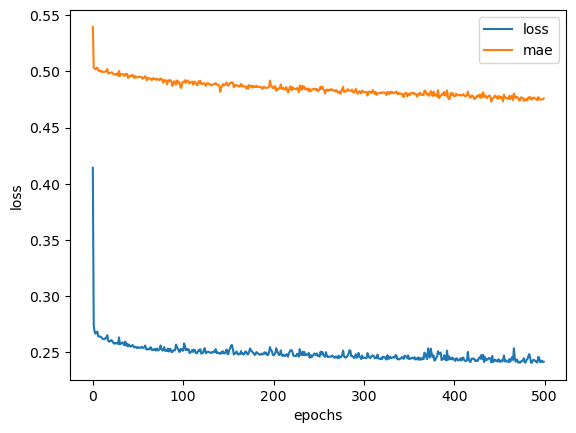

In [1485]:
tf.random.set_seed(42)

# 1. Create the model (based on insurance_model_2)
model_a = tf.keras.Sequential([
    tf.keras.layers.Dense(100, name="hidden_layer_1"),
    tf.keras.layers.Dense(100, name="hidden_layer_2"),
    tf.keras.layers.Dense(50, name="hidden_layer_3"),
    tf.keras.layers.Dense(1, name="output_layer")
], name="model_a")

# 2. Compile the model
model_a.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=["mae"])

# 3. Fit the model
history_model_a = model_a.fit(X_train_normal, y_train, epochs=500, verbose=0)

# Evaluate our insurance model trained on normalized data

evaluate_result = model_a.evaluate(X_test_normal, y_test)

# Plot history (also known as a loss curve or training curve)
pd.DataFrame(history_model_a.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [1486]:
# Predict the first n results of train
predict_sample = X_train.head(10)
record_to_predict = ct.transform(predict_sample)
predict_result = model_a.predict(record_to_predict)

predict_sample

1/1 [==============================] - 0s 29ms/step


5m_open_price  5m_high_price  5m_low_price  5m_close_price  5m_volume  \
794          270.3          270.6         270.2           270.6    392.648   
771          270.3          270.5         270.2           270.4    537.495   
984          266.7          266.7         265.7           266.2   4408.005   
686          272.1          272.2         272.0           272.1    339.510   
725          272.2          272.3         272.1           272.2    305.757   
484          272.3          272.7         272.2           272.6    335.344   
81           278.2          278.3         278.2           278.3    238.956   
152          274.2          274.3         274.0           274.2    955.694   
430          271.1          271.3         271.0           271.2    305.309   
204          274.8          275.1         274.6           274.9    696.580   

     5m_quote_asset_volume  5m_number_of_trades  \
794           1.061514e+05                  419   
771           1.452952e+05                  481   
984           1.173059e+06                 2163   
686           9.238950e+04                  378   
725           8.323562e+04                  323   
484           9.136738e+04                  523   
81            6.649513e+04                  207   
152           2.620065e+05                  451   
430           8.278968e+04                  338   
204           1.914753e+05                  515   

     5m_taker_buy_base_asset_volume  5m_taker_buy_quote_asset_volume  \
794                         216.362                       58500.5116   
771                         184.715                       49938.7849   
984                        1818.580                      484021.1465   
686                         166.597                       45340.0978   
725                         101.599                       27663.8447   
484                         192.030                       52324.6416   
81                          208.276                       57959.9501   
152                         303.408                       83191.6922   
430                         178.032                       48282.9350   
204                         398.766                      109613.2116   

      lockPrice  closePrice  totalBets  totalAmount  bullBets  bullAmount  \
794  270.349781  270.342728         71    19.403689        38   11.775775   
771  270.474056  270.360000         89    20.241914        35    4.538054   
984  267.279542  266.217012         78    17.308267        30    7.971755   
686  272.082790  272.140000         63    13.233704        48    7.489023   
725  272.160000  272.210000         48     8.730622        30    5.889182   
484  272.340000  272.580000        101    21.174706        56   15.229398   
81   278.255691  278.120000         75    13.520395        40    4.984597   
152  274.189590  274.280000        106    36.403541        74   27.553223   
430  271.200000  271.130000         89    10.980895        47    7.879992   
204  274.840000  275.110000        103    11.705561        49    5.920907   

     bearBets  bearAmount  
794        33    7.627914  
771        54   15.703859  
984        48    9.336512  
686        15    5.744682  
725        18    2.841440  
484        45    5.945308  
81         35    8.535798  
152        32    8.850318  
430        42    3.100902  
204        54    5.784654

In [1504]:
y_train.head(10), predict_result

(795    1
 772    0
 985    1
 687    0
 726    0
 485    0
 82     0
 153    1
 431    0
 205    1
 Name: position_code, dtype: int8,
 array([[0.6160323 ],
        [0.46027943],
        [0.4595472 ],
        [0.42773804],
        [0.44467193],
        [0.6119751 ],
        [0.45478866],
        [0.5708801 ],
        [0.5208005 ],
        [0.5160197 ]], dtype=float32))

In [1513]:
np.squeeze(np.rint(predict_result)) == y_train.head(10)

795     True
772     True
985    False
687     True
726     True
485    False
82      True
153     True
431    False
205     True
Name: position_code, dtype: bool

### Best result
* 100 (relu) -> 10 (relu) -> 1 (relu) -> 1 (output linear)
* Adam(learning_rate: 0.001)
* loss mse
* Epochs: 200

0.2500512897968292

In [1489]:
model_a.summary()

Model: "model_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 100)               1800      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 50)                5050      
                                                                 
 output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 17,001
Trainable params: 17,001
Non-trainable params: 0
_________________________________________________________________


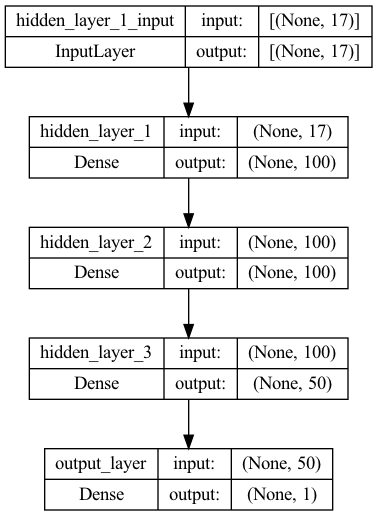

In [1490]:
plot_model(model_a, show_shapes=True)

In [1491]:
# Save model using the SavedModel format
!mkdir -p saved_model
model_a.save('saved_model/prediction_linear_regression_model_a')

INFO:tensorflow:Assets written to: saved_model/prediction_linear_regression_model_a/assets


In [1492]:
# Save model using the HDF5 format
!mkdir -p hdf5

# The '.h5' extension indicates that the model should be saved to HDF5
model_a.save('hdf5/prediction_linear_regression_model_a.h5')